# Predictions on growth of confirmed Novel Coronavirus (2019-nCoV) cases in countries 
                      By Bohan updated on April 21, 2020  
## Goal: Make an educated guess on when the spread of the novel coronavirus will stabilize (i.e. when the things will get better) in different countries

## Method: 
1. Use the data from China as an example to create logistic models for different countries 
2. Use R^2 to evaluate goodness of fit
3. Use inflection point to predict the turning point (i.e. when the number of newly confirmed cases per day will start to decrease)
4. Use 99.9% of the top horizontal asymptote value to predict when the situation wil stablize (i.e. the number of newly confirmed cases is closed to zero)

## Data: 
Publically available source from 2019 Novel Coronavirus COVID-19 (2019-nCoV) Data Repository by Johns Hopkins CSSE  
https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv


## Disclaimer: 
### 1. The model assumes that everything stays constant, so the conclusions will be affected both positively and negatively by dramatic changes such as new travel restictions, shortage of health care supplies, ect
### 2. Only confirmed cases were included, so the result depends number of tests done and it does not necessarily reflect the actual infected population in each countries
### 3. I intend to update every week and conclusion may be different in each update (due to new models being generated from latest data)


## Summary: 
### 0. Update on the parameter boundary  for model
### 1. The logistic model was applied to 102 countries
### 2. Mean turning point for these countries is on 2020-04-07 
(This is an understimate because only countries close to turning points can be modeled)
### 3. Mean CurveTop for these countries is on 2020-05-24
(This is also an understimate. If you check the graphs in the bottom, you will find that the numbers in some countires did not decrease as models predict )
### 4. The numbers of confirmed cases in some countires (such as  US, Italy, Spain, Canada) did not drop as predicted 
### 5. Comparing to last week, more countries can be modeled by logistic model. Russia, Turkey, and Iran are prediced to exceed 8 milion cases 
### 6. From example graphs, there is no indication that the rate of increasing will drop soon as model prediction. 
It could be due to increased number of tests done but it also proves that the models tend to underestimate the situation.
### 7. The earliset time for situation in most countries to be stablized is in the begining of June 
  

In [1]:
import numpy as np;  # useful for many scientific computing in Python
import pandas as pd; # primary data structure library
import scipy as sp; # for statistical tests
import matplotlib.pyplot as plt; # for plotting
import seaborn as sns; # for heatmaps

# add custom converters for timestamps when plotting
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
# data from 2019 Novel Coronavirus COVID-19 (2019-nCoV) Data Repository by Johns Hopkins CSSE
# https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv

df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'); # import file
df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,555,607,665,714,784,840,906,933,996,1026
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,433,446,467,475,494,518,539,548,562,584
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,1825,1914,1983,2070,2160,2268,2418,2534,2629,2718
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,601,638,646,659,673,673,696,704,713,717
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,19,19,19,19,19,19,19,24,24,24


## Create China data frame as an example
The location data and Province/State data will be ignore 

In [3]:
China = df[df['Country/Region'] == 'China'];
China.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20
49,Anhui,China,31.8257,117.2264,1,9,15,39,60,70,...,991,991,991,991,991,991,991,991,991,991
50,Beijing,China,40.1824,116.4142,14,22,36,41,68,80,...,589,589,589,589,590,593,593,593,593,593
51,Chongqing,China,30.0572,107.8740,6,9,27,57,75,110,...,579,579,579,579,579,579,579,579,579,579
52,Fujian,China,26.0789,117.9874,1,5,10,18,35,59,...,351,352,352,353,353,353,354,355,355,355
53,Gansu,China,37.8099,101.0583,0,2,2,4,7,14,...,139,139,139,139,139,139,139,139,139,139


In [4]:
# calculate sums for the entire country
China_sum = China.iloc[:,4:].sum(axis=0);

## Create logistic model as
## f(x) = a / (1 + e^(-c * (x - d)) ) + b
    where x is time, 
    f(x) is Percentage confirmed cases over entire population,
    a,b,c,d are fitting parameters
    c > 0 (update on April 21, because if c<0, the top horizontal asymptote is b)

### The inflection point is at x =  -ln( abs(1 - 2a/(a-b) )) / c +d
### The top horizontal asymptote is f(x) = a + b

In [5]:
# create logistic function
def func(x, a,b,c,d): 
    return a / (1. + np.exp(-1.*c * (x - d))) + b

In [6]:
 # import curve_fit function and fit the curve
from scipy.optimize import curve_fit;
# repeate fitting three time using consecutive parameters
popt, pcov = curve_fit(func, np.arange(len(China_sum)), China_sum.to_numpy(), p0=[China_sum.iloc[-1], 0,  1,  0],
                      bounds=((-np.inf, -np.inf, 0, -np.inf), (np.inf, np.inf, np.inf, np.inf)) );
popt, pcov = curve_fit(func, np.arange(len(China_sum)), China_sum.to_numpy(), p0=popt,
                      bounds=((-np.inf, -np.inf, 0, -np.inf), (np.inf, np.inf, np.inf, np.inf)) );
popt, pcov = curve_fit(func, np.arange(len(China_sum)), China_sum.to_numpy(), p0=popt,
                      bounds=((-np.inf, -np.inf, 0, -np.inf), (np.inf, np.inf, np.inf, np.inf)) );
y_fit = func(np.arange(len(China_sum)), popt[0],popt[1],popt[2],popt[3]);

In [7]:
# create a function to plot data
def p_model(s, y_fit, name, fst):
    # s: pandas series containing number of confirmed cases
    # y_fit: 1-d array containing model data 
    # name: name of country (str)
    # fst: first day of the data set (str)
    
    plt.figure(figsize=(20,15));
    plt.plot(pd.to_datetime(fst)+pd.to_timedelta(np.arange(len(s)), unit='day'), s.to_numpy(),'b', label=name);
    plt.plot(pd.to_datetime(fst)+pd.to_timedelta(np.arange(len(y_fit)), unit='day'), y_fit,'r--', label='Simulated');
    plt.legend(fontsize=20);
    plt.ylabel('Number of confirmed cases', fontsize=20);
    plt.title('Cumulative number of confirmed cases', fontsize=20);
    plt.xlabel('Date', fontsize=20);
    plt.show();

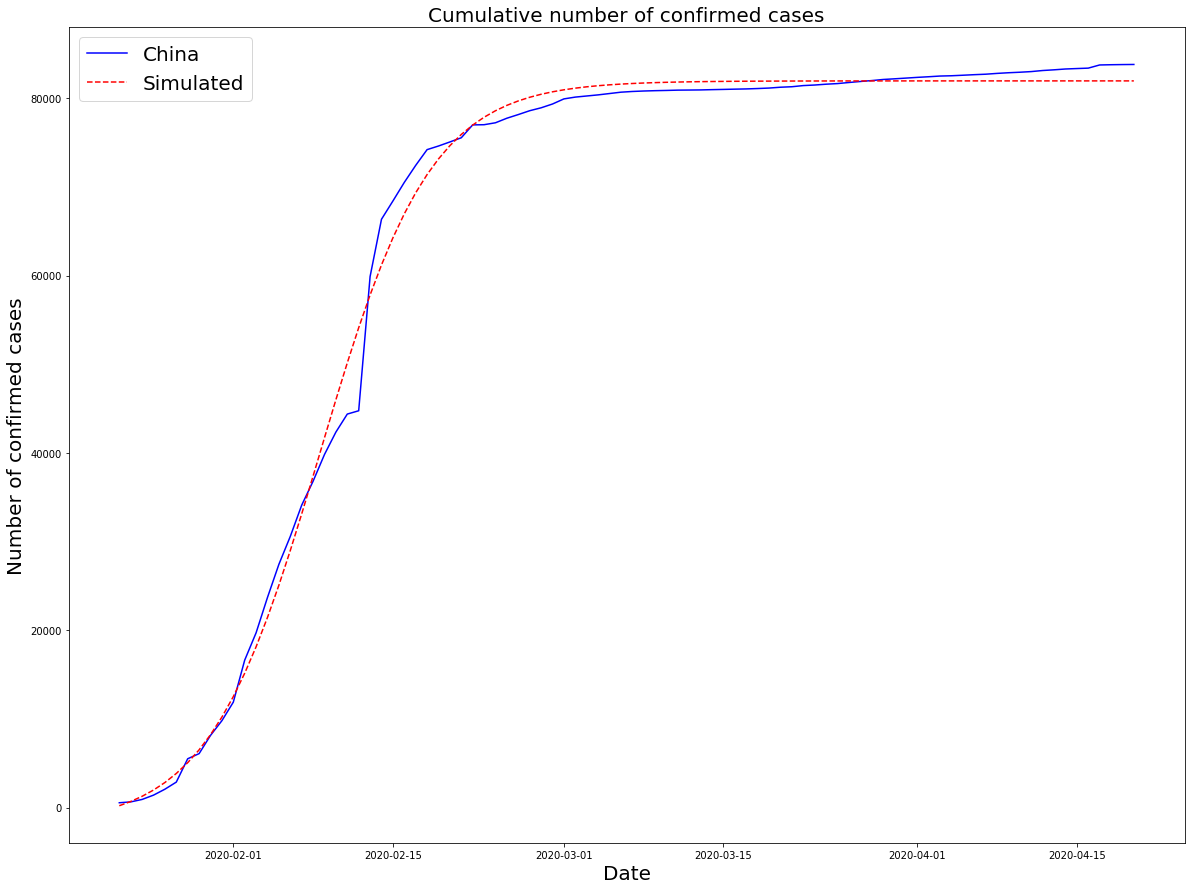

In [8]:
# plot for China
p_model(China_sum, y_fit, 'China', China_sum.index[0])

In [9]:
# define the function to caculate R^2 using residual sum of squares
def r_square(y, y_fit):
    # residual sum of squares
    ss_res = np.sum((y - y_fit) ** 2)

    # total sum of squares
    ss_tot = np.sum((y - np.mean(y)) ** 2)

    # r-squared
    r2 = 1 - (ss_res / ss_tot)
    return r2

In [10]:
# The closer the R^2 is to 1, the better the fitting
print('R^2 = ', r_square(China_sum.to_numpy(), y_fit))

R^2 =  0.9956614851311829


In [11]:
# find % when the confirmed population stablized on March 18
# the inflection point is at fp = a/2
# after solving for x in the logistic equation:
# x = -ln(abs(1-a/(fb-b)))/c + d = -ln(abs(1-2a/(a-b)))/c + d
# caculate this date:
iday = -np.log(abs(1-2*popt[0]/(popt[0]-popt[1])))/popt[2] + popt[3];
print('The day reaches the turning point is on: ',
      pd.to_datetime(China_sum.index[0]) + pd.to_timedelta(iday, unit='day'));

The day reaches the turning point is on:  2020-02-08 19:56:01.333622400


In [12]:
# top horizontal horizontal asymptotes is a + b (popt[0] + popt[1])
# time to reach 99.9% of asymptote is at y_hor = 0.999*(a + b)
# after solving for x in the logistic equation:
# x = -ln(abs(1-a/(y_hor-b)))/c + d
# caculate this date:
dday = -np.log(abs(1-popt[0]/(0.999*(popt[0]+popt[1])-popt[1])))/popt[2] + popt[3];
print('The day reaches the top of the curve is on: ',
      pd.to_datetime(China_sum.index[0]) + pd.to_timedelta(dday, unit='day'));
print('The total number of confirmed cases is ', popt[0]+popt[1]);

The day reaches the top of the curve is on:  2020-03-13 05:00:16.138800
The total number of confirmed cases is  81964.21599622295


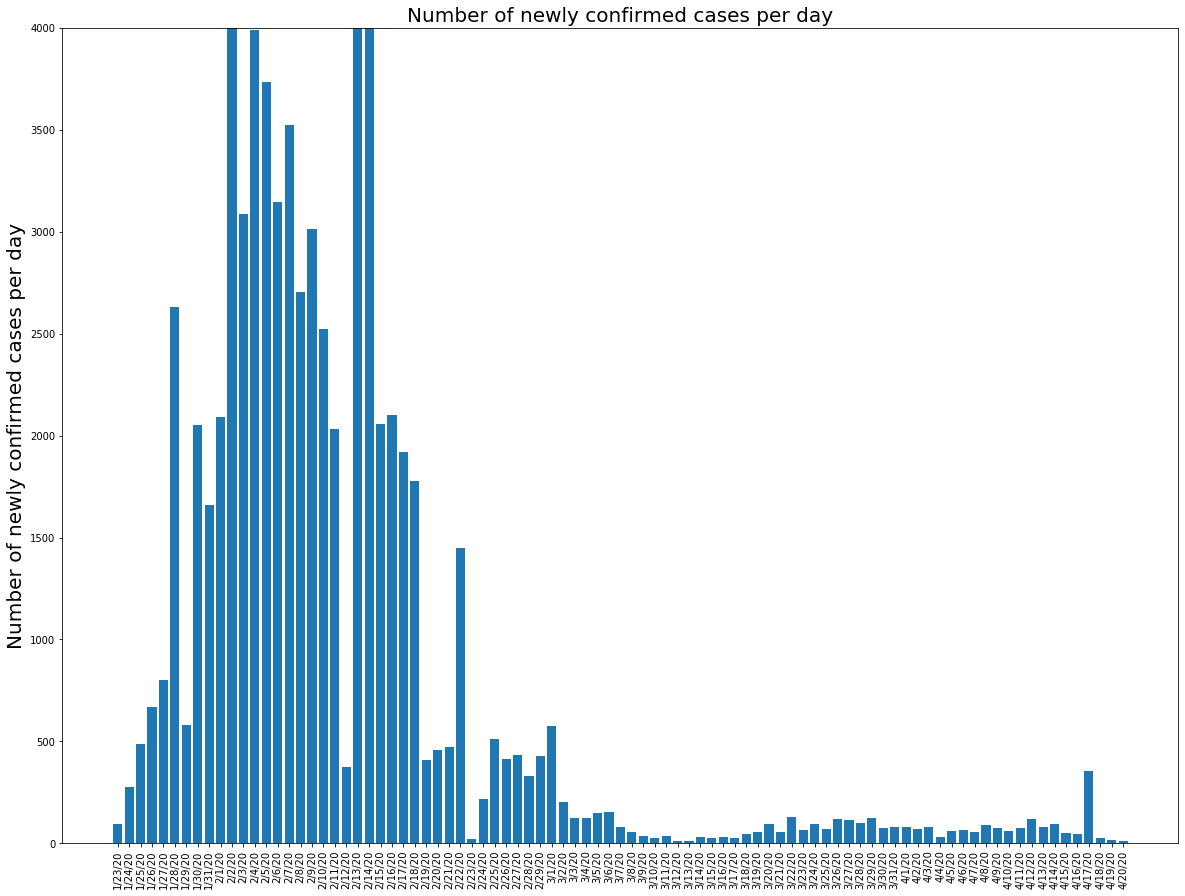

In [13]:
# plot number of newly confirmed cases
plt.figure(figsize=(20,15));
plt.bar(China_sum.index[1:], China_sum.to_numpy()[1:]-China_sum.to_numpy()[:-1]);
plt.xticks(rotation='vertical');
plt.ylim((0,4000));
plt.ylabel('Number of newly confirmed cases per day', fontsize=20);
plt.title('Number of newly confirmed cases per day', fontsize=20);

## Summary:
1. As shown in the bar graph, the number of newly confirmed cases did decrease after 2/7/2020 as perdicted by the model but it increased again on 2/13/2020.
2. After 3/8/2020, the number of newly confirmed cases stablized which closely matches the modelperdiction: 3/11/2020.  
3. Therefore, the model is suitable for making guesses.

# Predictions on Other countries

In [14]:
# fitting parameters for China
popt_china = popt;
# for storing data
POPT = [];
PCOV = [];
R2 = [];
Iday = [];
Dday = [];
NAME = [];
TotalC = [];

# I will ignore number of confirmed cases below 400
# because good model cannot be generated from small sample size
countries = df['Country/Region'].unique()
for ct in np.arange(len(countries)):
    
    # caculate sums per country
    df1 = df[df['Country/Region'] == countries[ct]].iloc[:, 4:].sum(axis=0);
    
    # I will ignore number of confirmed cases below 400
    # because good model cannot be generated from small sample size
    if df1[-1] < 400:
        continue
    
    # try to fit the curve
    try:
        # repeate fitting three time starting with parameters for China
        popt, pcov = curve_fit(func, np.arange(len(df1)), df1.to_numpy(), 
                               p0= [df1.iloc[-1], popt_china[1],popt_china[2],popt_china[3]], 
                      bounds=((-np.inf, -np.inf, 0, -np.inf), (np.inf, np.inf, np.inf, np.inf)) );
        popt, pcov = curve_fit(func, np.arange(len(df1)), df1.to_numpy(), p0=popt, 
                      bounds=((-np.inf, -np.inf, 0, -np.inf), (np.inf, np.inf, np.inf, np.inf)) );
        popt, pcov = curve_fit(func, np.arange(len(df1)), df1.to_numpy(), p0=popt, 
                      bounds=((-np.inf, -np.inf, 0, -np.inf), (np.inf, np.inf, np.inf, np.inf)) );
    except RuntimeError:
        try: 
            # repeate fitting three time starting with zeros
            popt, pcov = curve_fit(func, np.arange(len(df1)), df1.to_numpy(), 
                      bounds=((-np.inf, -np.inf, 0, -np.inf), (np.inf, np.inf, np.inf, np.inf)) );
            popt, pcov = curve_fit(func, np.arange(len(df1)), df1.to_numpy(), p0=popt, 
                      bounds=((-np.inf, -np.inf, 0, -np.inf), (np.inf, np.inf, np.inf, np.inf)) );
            popt, pcov = curve_fit(func, np.arange(len(df1)), df1.to_numpy(), p0=popt, 
                      bounds=((-np.inf, -np.inf, 0, -np.inf), (np.inf, np.inf, np.inf, np.inf)) );
        except RuntimeError:
            continue
    
    # calculate model curve
    y_fit = func(np.arange(len(df1)), popt[0],popt[1],popt[2],popt[3]);
    
    # calculate R^2
    # The closer the R^2 is to 1, the better the fitting
    r2 = r_square(df1.to_numpy(), y_fit);
    
    # ignore if R^2 value is less than 0.98 or above one (indeicating poor fits)
    if r2 < 0.98 or r2 > 1:
        continue
    
    # print country name
    print(countries[ct]);
        
    # print R^2
    print('R^2 = ', r2);
    
    # caculate turning point
    iday = -np.log(abs(1-2*popt[0]/(popt[0]-popt[1])))/popt[2] + popt[3];
    print('The day reaches the turning point is on: ',
          pd.to_datetime(df1.index[0]) + pd.to_timedelta(iday, unit='day'));
    
    # caculate date reaches mzx:
    dday = -np.log(abs(1-popt[0]/(0.999*(popt[0]+popt[1])-popt[1])))/popt[2] + popt[3];
    print('The day reaches the top of the curve is on: ',
          pd.to_datetime(df1.index[0]) + pd.to_timedelta(dday, unit='day'));
    print('The total number of confirmed cases is ', popt[0]+popt[1]);
    
    # save data
    POPT.append(popt);
    PCOV.append(pcov);
    R2.append(r2);
    Iday.append(pd.to_datetime(df1.index[0]) + pd.to_timedelta(iday, unit='day'));
    Dday.append(pd.to_datetime(df1.index[0]) + pd.to_timedelta(dday, unit='day'));
    TotalC.append(popt[0]+popt[1]);
    NAME.append(countries[ct]);
    
# convert to numpy array
POPT = np.array(POPT);
PCOV = np.array(PCOV);
R2 = np.array(R2);

Afghanistan
R^2 =  0.9983703588452251
The day reaches the turning point is on:  2020-04-14 11:09:01.725552
The day reaches the top of the curve is on:  2020-06-04 03:26:29.853744
The total number of confirmed cases is  1512.3794646032625
Albania
R^2 =  0.9975142878224224
The day reaches the turning point is on:  2020-04-03 08:15:20.227190400
The day reaches the top of the curve is on:  2020-05-25 22:09:31.633401600
The total number of confirmed cases is  616.7837823793031
Algeria
R^2 =  0.9966148318858908
The day reaches the turning point is on:  2020-04-07 01:59:10.200911999
The day reaches the top of the curve is on:  2020-05-21 13:29:46.704767999
The total number of confirmed cases is  2925.461637919241
Andorra
R^2 =  0.9968968033771006
The day reaches the turning point is on:  2020-03-30 17:29:28.675795200
The day reaches the top of the curve is on:  2020-05-07 19:49:00.913296
The total number of confirmed cases is  710.1100754515587
Argentina
R^2 =  0.9966514279343469
The day reac

France
R^2 =  0.9952362405471458
The day reaches the turning point is on:  2020-04-10 21:23:58.203081600
The day reaches the top of the curve is on:  2020-06-08 13:46:44.025715199
The total number of confirmed cases is  215192.78926694032
Georgia
R^2 =  0.9979780102264889
The day reaches the turning point is on:  2020-04-20 10:48:31.223318400
The day reaches the top of the curve is on:  2020-07-06 12:35:40.913030400
The total number of confirmed cases is  841.247604060873
Germany
R^2 =  0.9990502678632192
The day reaches the turning point is on:  2020-03-31 10:59:06.636307200
The day reaches the top of the curve is on:  2020-05-12 05:17:07.025280
The total number of confirmed cases is  148475.70666860515
Ghana
R^2 =  0.9856918455056433
The day reaches the turning point is on:  2020-05-27 20:53:42.791856
The day reaches the top of the curve is on:  2020-08-06 14:15:09.111571199
The total number of confirmed cases is  43230.59335386221
Greece
R^2 =  0.9992404585016685
The day reaches the

The day reaches the turning point is on:  2020-04-12 06:01:44.110790400
The day reaches the top of the curve is on:  2020-06-07 22:29:38.516294400
The total number of confirmed cases is  1710.0410044680514
Norway
R^2 =  0.9989821169918629
The day reaches the turning point is on:  2020-03-26 17:20:34.301558400
The day reaches the top of the curve is on:  2020-05-12 13:28:01.619040
The total number of confirmed cases is  7180.220979396733
Oman
R^2 =  0.9984137747456315
The day reaches the turning point is on:  2020-05-03 13:07:26.178614400
The day reaches the top of the curve is on:  2020-07-03 22:27:44.435289600
The total number of confirmed cases is  7929.52161549034
Pakistan
R^2 =  0.9972506609137946
The day reaches the turning point is on:  2020-04-14 04:34:20.451331200
The day reaches the top of the curve is on:  2020-06-11 21:06:22.488307200
The total number of confirmed cases is  12472.704369985668
Panama
R^2 =  0.9987256159493758
The day reaches the turning point is on:  2020-04-

In [15]:
print('Number of Countries: ', len(NAME));
Pred = pd.DataFrame(data = {'Country/Region': NAME, 'R^2': R2, 'TurningP': Iday, 'CurveTop': Dday, 'TotalConfirmed': TotalC})
Pred.sort_values(by=['TotalConfirmed'], ascending=False).style.bar(subset=['TotalConfirmed'])

Number of Countries:  102


,Country/Region,R^2,TurningP,CurveTop,TotalConfirmed
98,US,0.998674,2020-04-08 04:02:19.548470400,2020-05-20 13:23:16.145232,869145
36,France,0.995236,2020-04-10 21:23:58.203081600,2020-06-08 13:46:44.025715199,215193
87,Spain,0.998139,2020-03-31 22:06:11.582236800,2020-05-13 00:04:07.017686400,199500
81,Russia,0.999767,2020-04-26 16:34:19.982092800,2020-06-08 04:09:17.640230400,188578
51,Italy,0.997886,2020-03-28 16:50:22.112620800,2020-05-21 22:36:16.997760,183940
96,United Kingdom,0.99932,2020-04-10 07:32:13.458451199,2020-05-25 04:39:39.213244800,150656
38,Germany,0.99905,2020-03-31 10:59:06.636307200,2020-05-12 05:17:07.025280,148476
93,Turkey,0.999134,2020-04-11 12:30:20.734588800,2020-05-20 18:19:27.876921600,108972
47,Iran,0.998815,2020-03-31 19:58:14.692281600,2020-06-01 11:28:10.201353600,92711.1
20,China,0.995661,2020-02-08 19:56:01.331289600,2020-03-13 05:00:16.175260800,81964.2


In [16]:
print('Mean turning point for these countries is ', Pred['TurningP'].mean());
print('Mean CurveTop for these countries is ', Pred['CurveTop'].mean());

Mean turning point for these countries is  2020-04-07 14:27:15.727531264
Mean CurveTop for these countries is  2020-05-24 14:33:20.449633536


## Examples

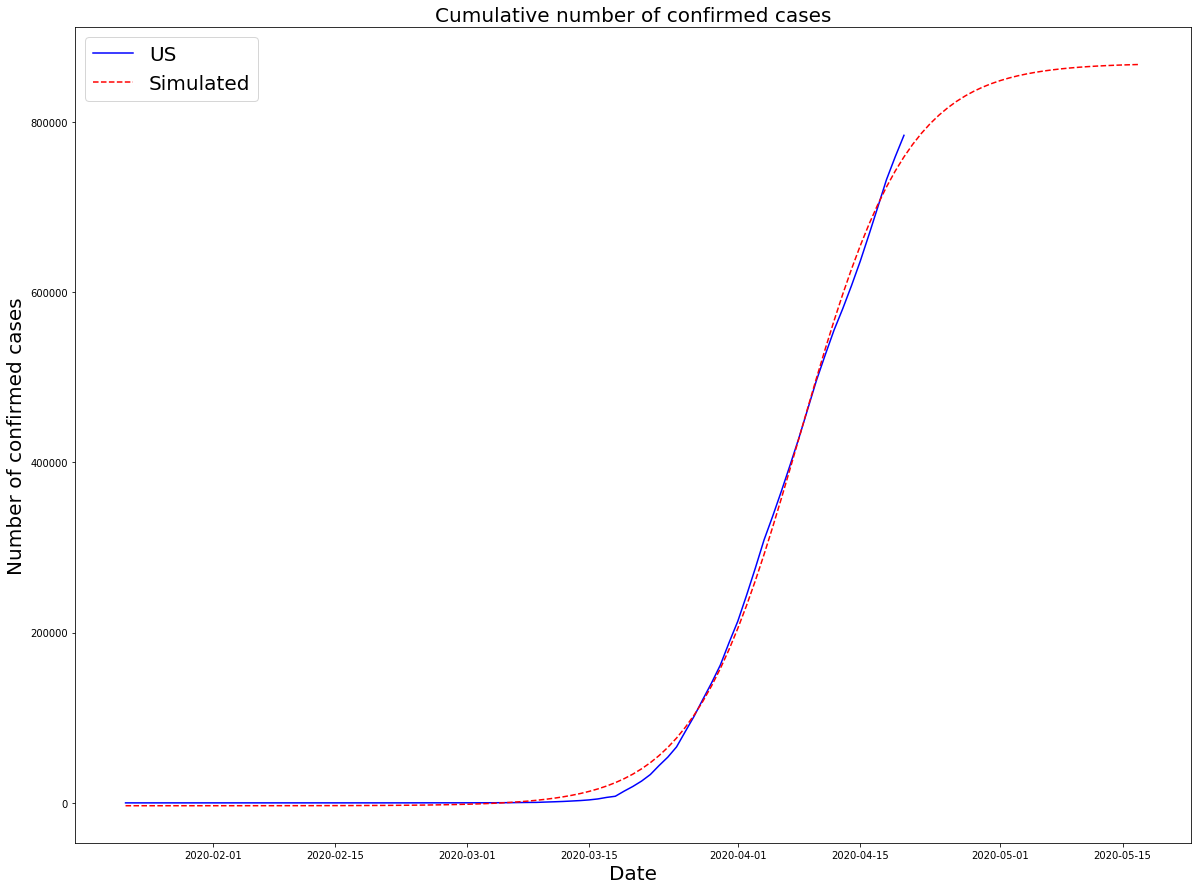

In [17]:
# US
example = 'US';
df2 = df[df['Country/Region'] == example].iloc[:, 4:].sum(axis=0);
popt2 = POPT[Pred.index[Pred['Country/Region'] == example], :];
y_fit2 = func(np.arange(len(df2)*1.3), popt2[0,0],popt2[0,1],popt2[0,2],popt2[0,3]);
p_model(df2, y_fit2, example, df2.index[0]);

In [18]:
popt2

array([[ 8.72504490e+05, -3.35919756e+03,  1.62844780e-01,
         7.71209965e+01]])

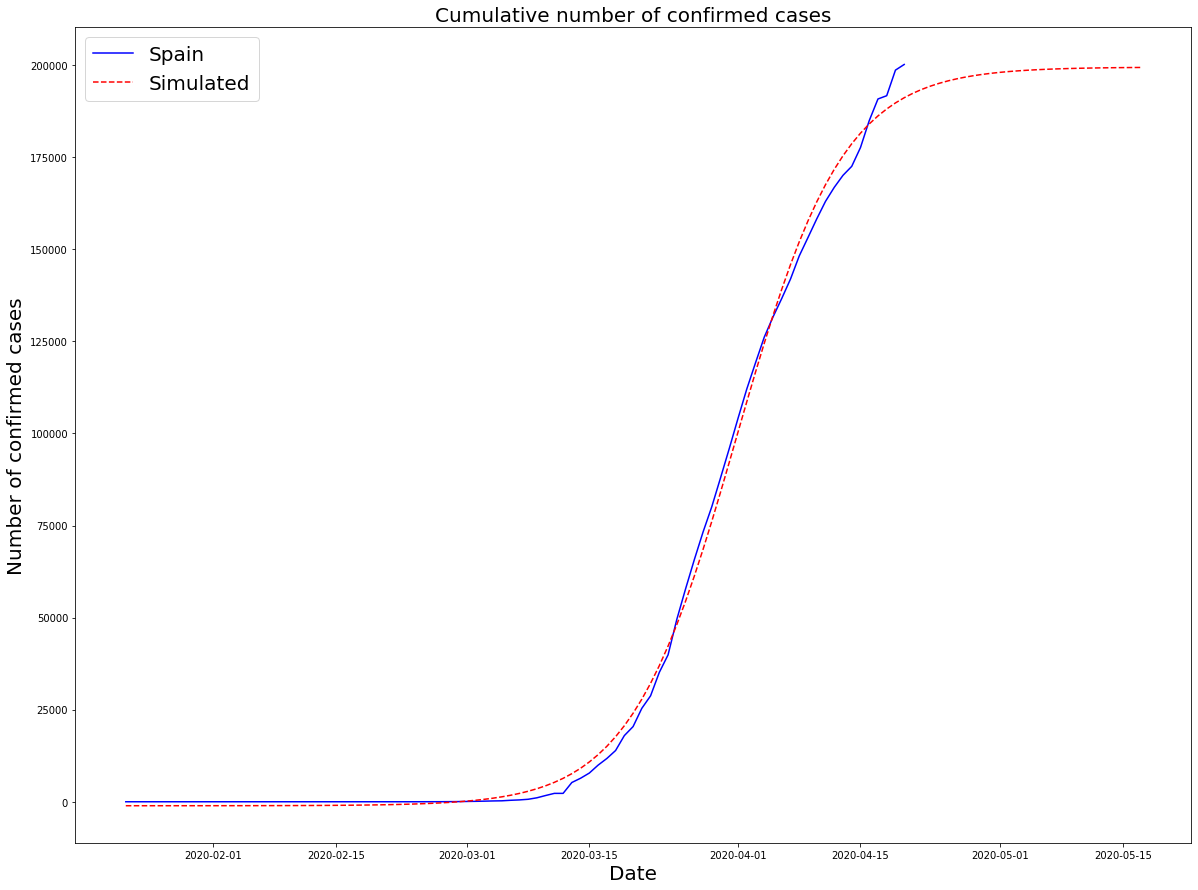

In [21]:
# Spain
example = 'Spain';
df2 = df[df['Country/Region'] == example].iloc[:, 4:].sum(axis=0);
popt2 = POPT[Pred.index[Pred['Country/Region'] == example], :];
y_fit2 = func(np.arange(len(df2)*1.3), popt2[0,0],popt2[0,1],popt2[0,2],popt2[0,3]);
p_model(df2, y_fit2, example, df2.index[0]);

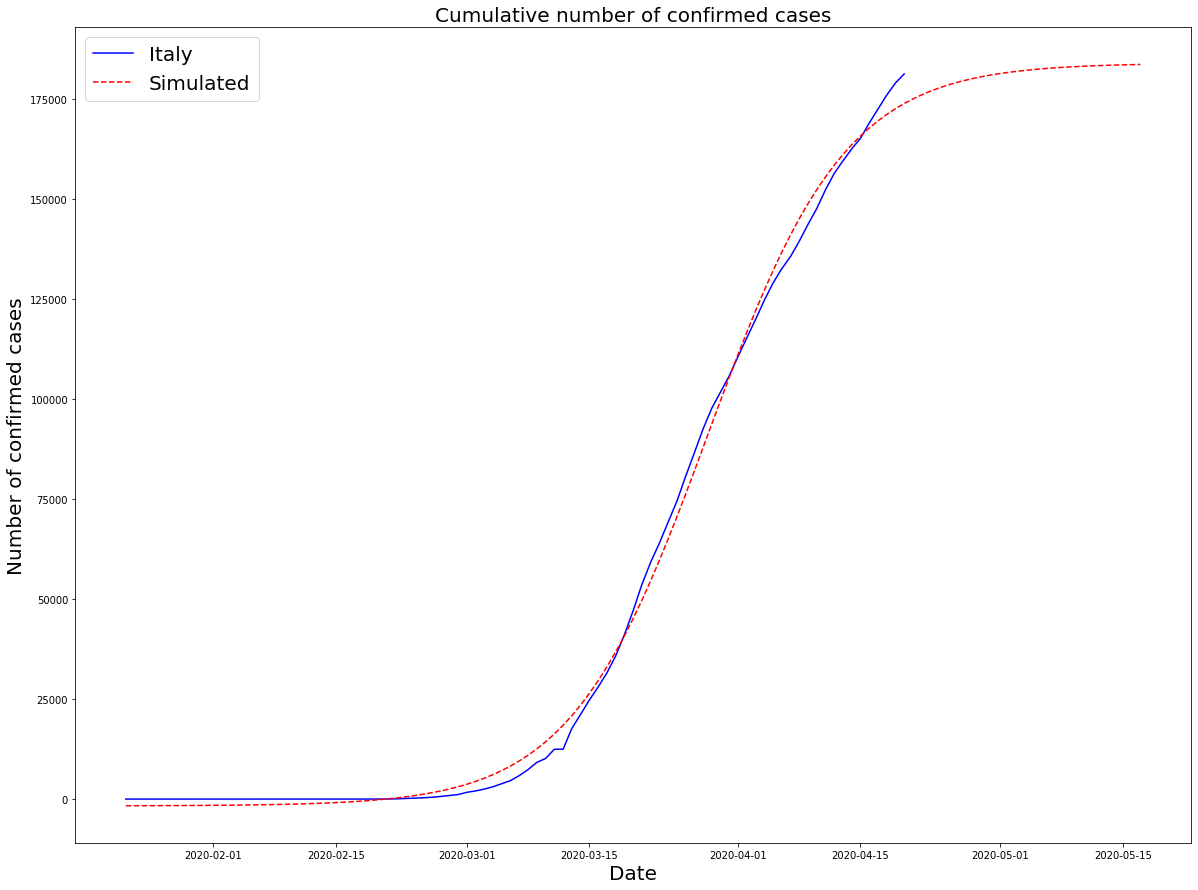

In [22]:
# Italy
example = 'Italy';
df2 = df[df['Country/Region'] == example].iloc[:, 4:].sum(axis=0);
popt2 = POPT[Pred.index[Pred['Country/Region'] == example], :];
y_fit2 = func(np.arange(len(df2)*1.3), popt2[0,0],popt2[0,1],popt2[0,2],popt2[0,3]);
p_model(df2, y_fit2, example, df2.index[0]);

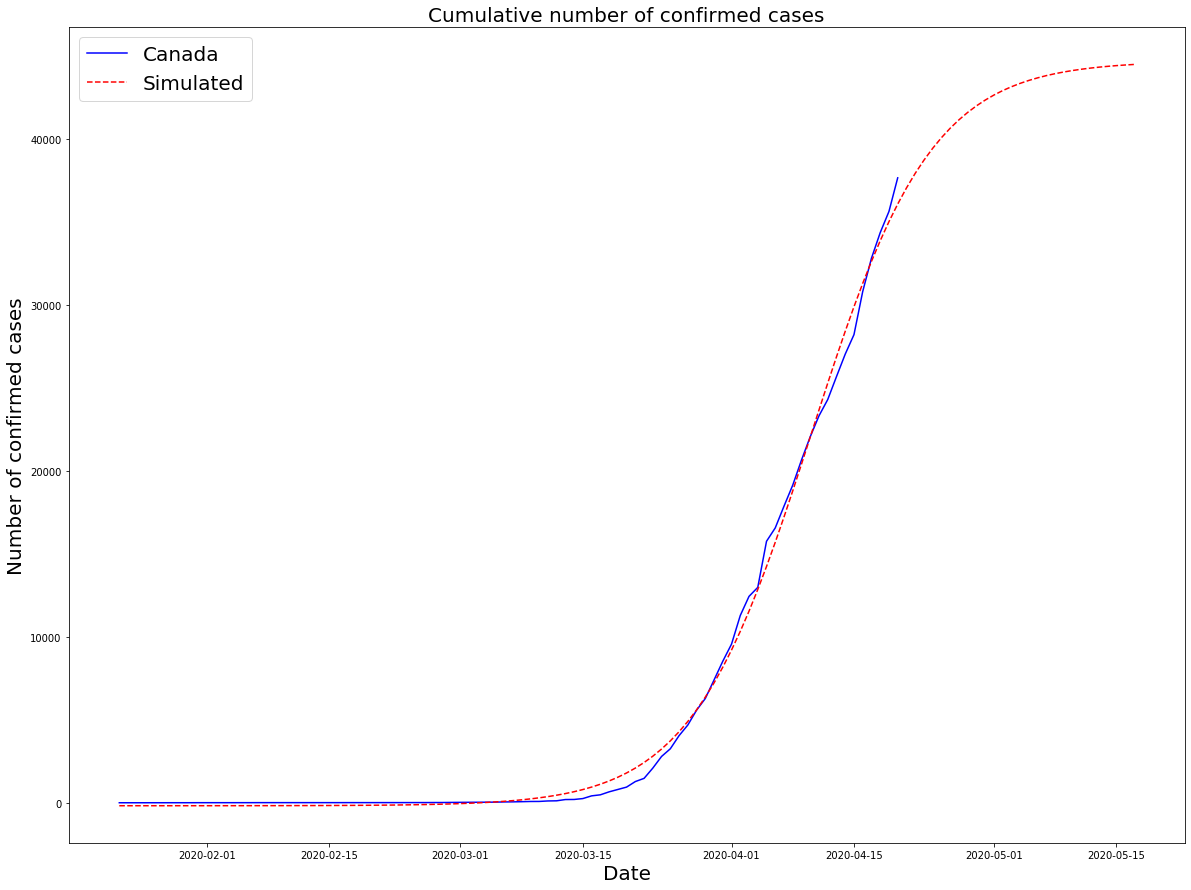

In [23]:
# Canada
example = 'Canada';
df2 = df[df['Country/Region'] == example].iloc[:, 4:].sum(axis=0);
popt2 = POPT[Pred.index[Pred['Country/Region'] == example], :];
y_fit2 = func(np.arange(len(df2)*1.3), popt2[0,0],popt2[0,1],popt2[0,2],popt2[0,3]);
p_model(df2, y_fit2, example, df2.index[0]);